In [1]:
#Optimizacion Bayesiana de hiperparametros de  rpart
#funciona automaticamente con EXPERIMENTOS
#va generando incrementalmente salidas para kaggle

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

library("data.table")
library("rlist")
library("yaml")

library("rpart")
library("parallel")

#paquetes necesarios para la Bayesian Optimization
library("DiceKriging")
library("mlrMBO")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,492757,26.4,1086987,58.1,641780,34.3
Vcells,941618,7.2,8388608,64.0,1753993,13.4


Warning message:
“package ‘data.table’ was built under R version 3.6.3”
Warning message:
“package ‘rlist’ was built under R version 3.6.3”
Warning message:
“package ‘yaml’ was built under R version 3.6.3”
Warning message:
“package ‘rpart’ was built under R version 3.6.3”
Warning message:
“package ‘DiceKriging’ was built under R version 3.6.3”
Warning message:
“package ‘mlrMBO’ was built under R version 3.6.3”
Loading required package: mlr

Warning message:
“package ‘mlr’ was built under R version 3.6.3”
Loading required package: ParamHelpers

Warning message:
“package ‘ParamHelpers’ was built under R version 3.6.3”
Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Warning message:
“package ‘smoof’ was built under R version 3.6.3”
Loading required package: 

In [2]:
#para poder usarlo en la PC y en la nube
switch ( Sys.info()[['sysname']],
         Windows = { directory.root   <-  "M:\\" },   #Microsoft Windows
         Darwin  = { directory.root   <-  "~/dm/" },  #Apple MAC
         Linux   = { directory.root   <-  "~/buckets/b1/crudo/" }  #Entorno Google Cloud
       )
#defino la carpeta donde trabajo
setwd( directory.root )

In [34]:
kexperimento  <- 1002

kscript           <- "04.01 - RPART - Predict"
karch_generacion  <- "./datasets/paquete_premium_202011_ext.csv"
karch_aplicacion  <- "./datasets/paquete_premium_202101_ext.csv"
#karch_generacion  <- "./datasetsOri/paquete_premium_202011.csv"
#karch_aplicacion  <- "./datasetsOri/paquete_premium_202101.csv"




klog        <- paste0("./work/E",  kexperimento, "_rpart_log.txt" )
kkaggle     <- paste0("./kaggle/E",kexperimento, "_rpart_kaggle_" )

ksemilla_azar  <- 102191

GLOBAL_iteracion <- 99999

In [35]:
hiperparams = fread(klog)



In [36]:
hiperparams[order(-ganancia)][1:3]

fecha,cp,minsplit,minbucket,maxdepth,xval_folds,ganancia
<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>
20210904 011747,-0.1841972,1512,752,19,5,9292500
20210904 011629,-0.1702605,1485,738,11,5,9252500
20210904 012644,-0.6290823,1533,766,14,5,9233750


In [27]:
opt_param = hiperparams[order(-ganancia)][1]

In [28]:
opt_param[,c('fecha','xval_folds','ganancia'):=NULL]

In [29]:
opt_param

cp,minsplit,minbucket,maxdepth
<dbl>,<int>,<int>,<int>
-0.409818,1504,708,5


In [30]:
#cargo los datasets
dataset  <- fread(karch_generacion)   #donde entreno
dapply  <- fread(karch_aplicacion)    #donde aplico el modelo

In [31]:
particionar  <- function( data, division, agrupa="", campo="fold", start=1, seed=NA )
{
  if( !is.na( seed)  )   set.seed( seed )

  bloque  <- unlist( mapply(  function(x,y) { rep( y, x ) }, division, seq( from=start, length.out=length(division) )  ) )

  data[ , (campo) :=  sample( rep( bloque, ceiling(.N/length(bloque))) )[1:.N],
           by= agrupa ]
}
#------------------------------------------------------------------------------

ArbolesCrossValidation  <- function( data, param, qfolds, pagrupa, semilla )
{
  divi  <- rep( 1, qfolds )
  particionar( data, divi, seed=semilla, agrupa=pagrupa )

  ganancias  <- mcmapply( ArbolSimple, 
                          seq(qfolds), # 1 2 3 4 5  
                          MoreArgs= list( data, param), 
                          SIMPLIFY= FALSE,
                          mc.cores= 5 )   #se puede subir a 5 si posee Linux o Mac OS

  data[ , fold := NULL ]
  #devuelvo la primer ganancia y el promedio
  return( mean( unlist( ganancias )) *  qfolds )   #aqui normalizo la ganancia
}

#------------------------------------------------------------------------------
#esta funcion solo puede recibir los parametros que se estan optimizando
#el resto de los parametros se pasan como variables globales

EstimarGanancia  <- function( x )
{

   xval_folds  <- 5
   ganancia  <-  ArbolesCrossValidation( dataset, param=x, qfolds= xval_folds, pagrupa="clase_ternaria", semilla=ksemilla_azar )

    
     modelo  <- rpart("clase_ternaria ~ .",
                      data= dataset,
                      xval= 0,
                      control= x )

     #genero el vector con la prediccion, la probabilidad de ser positivo
     prediccion  <- predict( modelo, dapply)

     prob_baja2  <- prediccion[, "BAJA+2"]
     Predicted   <- ifelse( prob_baja2 > 0.025, 1, 0 )

     entrega  <-  as.data.table( list( "numero_de_cliente"=dapply$numero_de_cliente, "Predicted"=Predicted)  )

     #genero el archivo para Kaggle
     fwrite( entrega, 
             file= paste0(kkaggle, GLOBAL_iteracion, ".csv" ),
             sep=  "," )
   return( ganancia )
}
#------------------------------------------------------------------------------

ArbolSimple  <- function( fold_test, data, param )
{
  #genero el modelo
  modelo  <- rpart("clase_ternaria ~ .", 
                   data= data[ fold != fold_test, ],
                   xval= 0,
                   control= param )

  #aplico el modelo a los datos de testing, fold==2
  prediccion  <- predict( modelo, data[ fold==fold_test, ], type = "prob")

  prob_baja2  <- prediccion[, "BAJA+2"]

  ganancia_testing  <- sum(  data[ fold==fold_test ][ prob_baja2 >0.025,  ifelse( clase_ternaria=="BAJA+2", 48750, -1250 ) ] )

  return( ganancia_testing )
}

In [32]:
EstimarGanancia( opt_param )

[1] 9328750

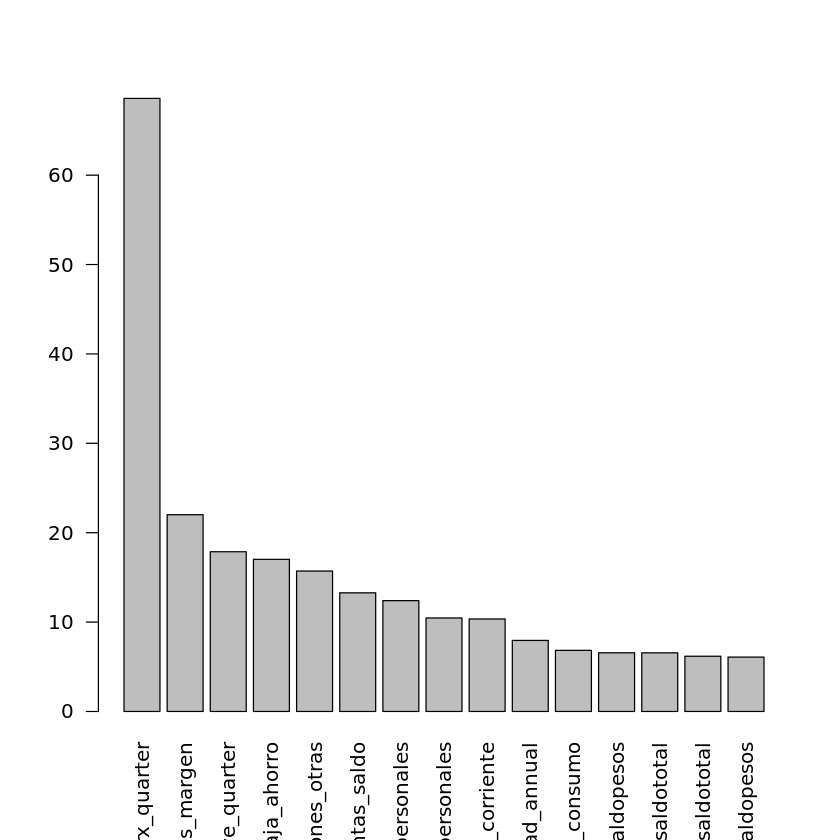

In [33]:
modelo  <- rpart("clase_ternaria ~ .", 
                   data= dataset,
                   xval= 0,
                   control= opt_param )

barplot(modelo$variable[1:15],las=2)

fwrite(data.table( names = names(modelo$variable.importance), importance = modelo$variable.importance),'./work/importance_FE.csv')